# Data Loading

In [2]:
using GeophysicalFlows, Random, Printf, Plots, JLD2, Statistics, CUDA, FFTW, HDF5
using LinearAlgebra: mul!, ldiv!
parsevalsum = FourierFlows.parsevalsum

dev = CPU()     # Device (CPU/GPU)

# ## Numerical, domain, and simulation parameters

 n, L  = 512, 2π              # grid resolution and domain length
 ν, nν = 0.005, 1             # viscosity coefficient and hyperviscosity order
 μ, nμ = 0.2, 0               # linear drag coefficient
    dt = 0.0002               # timestep
nsteps = 30750                # total number of steps
 nsubs = 25                   # number of steps between each plot


grid = TwoDGrid(dev; nx=n, Lx=L)
K = @. sqrt(grid.Krsq)        # a 2D array with the total wavenumber

x, y = grid.x, grid.y

nothing # hide

In [4]:
data = jldopen("/storage/p2/parfenyev/2d_turbulence/RL/alpha=0.2/alpha_0.2_v2.jld2")

nothing # hide

# Vorticity Visualization

In [ ]:
Num = 1230 # Number of snapshots under analysis

vort_h = [ Matrix{ComplexF64}(undef,Int(n/2+1),Int(n)) for _ in 1:Num ]
vort = [ Matrix{Float64}(undef,Int(n),Int(n)) for _ in 1:Num ]

for i in 1:Num
    number = i*nsubs
    name = "snapshots/sol/"*string(number)
    vort_h[i] = data[name] # Vorticity in k-space
    #vort_h[i][grid.Krsq .> 100] .= 0 # Fourier large-scale filter
    ldiv!(vort[i], grid.rfftplan, deepcopy(vort_h[i])) # Vorticity in x-space
end

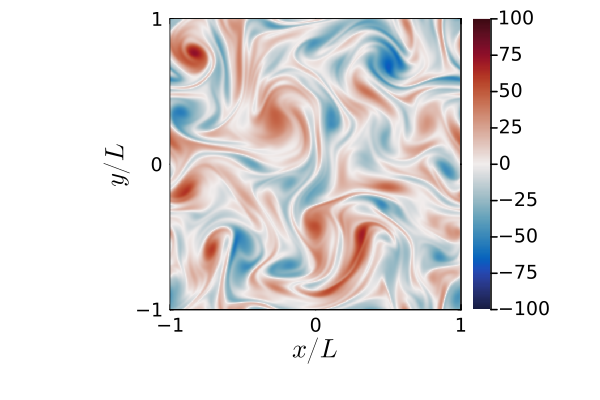

In [6]:
using LaTeXStrings

p = heatmap(2*x/L, 2*y/L, Array(vort[1]'),
         aspectratio = 1,
                   c = :balance,
                clim = (-100, 100),
               xlims = (-1, 1),
               ylims = (-1, 1),
              xticks = -3:3,
              yticks = -3:3,
              xlabel = L"x/L",
              ylabel = L"y/L",
          framestyle = :box, thickness_scaling=1.6, legend=true)

#savefig(p, "./vort.svg")

# Energy Spectrum

In [7]:
using Statistics

energy_h = [ Matrix{ComplexF64}(undef,Int(n/2+1),Int(n)) for _ in 1:Num ]
Ehr = [ Matrix{ComplexF64}(undef, Int(n),1) for _ in 1:Num ]
energy = zeros(Num)

E_av_rad = zeros(Int(n),1)

for i in 1:Num
    @. energy_h[i] = 1 / 2 * grid.invKrsq * abs2(vort_h[i])
    energy[i] = 1 / (grid.Lx * grid.Ly) * parsevalsum(energy_h[i], grid)
    
    kr, Ehr[i] = FourierFlows.radialspectrum(energy_h[i]/(grid.Lx * grid.Ly), grid, refinement=1)
    E_av_rad+=abs.(Ehr[i])/Num
end

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based xscale
└ @ Plots ~/.julia/packages/Plots/dIjan/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/dIjan/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based xscale
└ @ Plots ~/.julia/packages/Plots/dIjan/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/dIjan/src/utils.jl:106


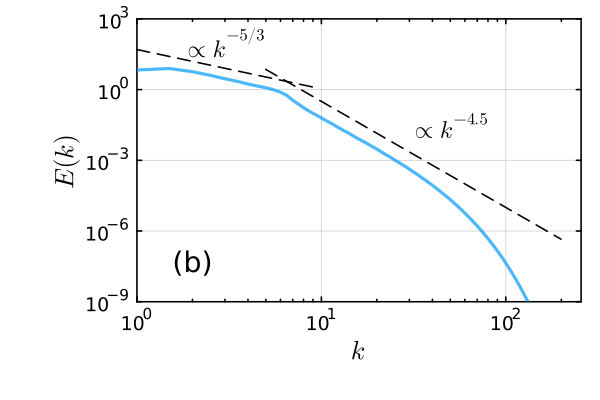

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based xscale
└ @ Plots ~/.julia/packages/Plots/dIjan/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/dIjan/src/utils.jl:106


In [8]:
kr, Ehr[1] = FourierFlows.radialspectrum(energy_h[1]/(grid.Lx * grid.Ly), grid, refinement=1)
norm = grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2) # normalization for Fourier transform from Parseval sum

plot(kr, E_av_rad*norm, thickness_scaling=1.6,
    linewidth = 2,
        alpha = 0.7,
       xlabel = L"k", ylabel = L"E(k)",
        xlims = (1, grid.nx/2), xminorticks=9,
        ylims = (1e-9,1e3),
       xscale = :log10, yscale = :log10,
       label = false,
   framestyle = :box)

plot!(kr[11:400], 0.1e5*kr[11:400].^(-4.5), label=false, ls=:dash, color=:black)
annotate!(50,0.3e-1,(L"\propto k^{-4.5}",10))

plot!(kr[1:20], 5e1*kr[1:20].^(-5/3), label=false, ls=:dash, color=:black)
annotate!(3,100,(L"\propto k^{-5/3}",10))

plt = annotate!(2, 5e-8, ("(b)",12))

#savefig(plt, "./spectr.svg")

In [10]:
println("Re=", sqrt(2*mean(energy))*L/ν)
println("Rh=", sqrt(2*mean(energy))/(μ*L))

Re=7896.721978364503
Rh=5.000657610889717


# Velocity field

In [11]:
uh = [ Matrix{ComplexF64}(undef,Int(n/2+1),Int(n)) for _ in 1:Num ] 
vh = [ Matrix{ComplexF64}(undef,Int(n/2+1),Int(n)) for _ in 1:Num ]
u = [ Matrix{Float64}(undef,Int(n),Int(n)) for _ in 1:Num ]
v = [ Matrix{Float64}(undef,Int(n),Int(n)) for _ in 1:Num ]

for i in 1:Num
    @. uh[i] =   im * grid.l  * grid.invKrsq * vort_h[i]
    @. vh[i] = - im * grid.kr * grid.invKrsq * vort_h[i]
    ldiv!(u[i], grid.rfftplan, deepcopy(uh[i]))
    ldiv!(v[i], grid.rfftplan, deepcopy(vh[i]))
end

In [12]:
vort_to_save = zeros(512, 512, 1230)
u_to_save = zeros(512, 512, 1230) 
v_to_save = zeros(512, 512, 1230) 

for i in 1:1230
    vort_to_save[:,:,i]=vort[i]
    u_to_save[:,:,i]=u[i]
    v_to_save[:,:,i]=v[i]
end

In [ ]:
jldsave("./2d-turb-data.jld"; vel_x = u_to_save, vel_y = v_to_save, vort = vort_to_save)